In [463]:
#from keras.layers.preprocessing.image_preprocessing import ResizeMethod
from keras.utils.io_utils import path_to_string
from tqdm import tqdm
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import imutils
import copy
import glob 
import os
import cv2
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

In [464]:
LiteUNet_model=load_model('LiteU-Net.hdf5',compile=False)
LiteSRGANx2_model=load_model('LiteSRGANx2.h5',compile=False)
LiteSRGANx4_model=load_model('LiteSRGANx4.h5',compile=False)
IMAGE_SIZE=256
IMAGE_PATH="sample1.JPG"

In [465]:
def read_image(image_path,fixed_size=True):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if fixed_size == True:
        img = tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])
    
    img=np.array(img)
    return img

def get_padded_img(img,upsample):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img=tf.image.resize_with_pad(img, IMAGE_SIZE//upsample , IMAGE_SIZE//upsample,method=tf.image.ResizeMethod.BICUBIC)
    img = np.clip(img,0,1)
    return img

def BGR2RGB(img):
    return img[:,:,::-1]

def RGB2BGR(img):
    return img[:,:,::-1]

In [466]:
def get_super_resolution_version(img,upsample):
 
    #img=cv2.cvtColor(np.uint8(img),cv2.COLOR_BGR2RGB)
    #img = tf.image.convert_image_dtype(img, tf.float32)
    
    LR=  get_padded_img(img,upsample)
    SR=None
    if upsample==2:
        SR=LiteSRGANx2_model.predict(np.expand_dims(LR,0))
    else:
        SR=LiteSRGANx4_model.predict(np.expand_dims(LR,0))
        
    SR = (((SR + 1) / 2.) * 255).astype(np.uint8)
    SR=np.squeeze(SR)
    #SR=cv2.cvtColor(SR,cv2.COLOR_RGB2BGR)
        
    return SR
        

def apply_super_resolution(img):
    upsample=1
    # check for the cropped image new dimensions to see how will we do upsampling to obtain a (256*256*3) image
    if (img.shape[0] <= IMAGE_SIZE*0.25  and img.shape[1] <= IMAGE_SIZE*0.25):
    # Apply zero padding to obtain 64*64 image and then upsample the image to 256*256 using Light-SRGAN (2 upsampling blocks version)
        upsample=4
    elif(img.shape[0] <= IMAGE_SIZE * 0.5 and img.shape[1] <= IMAGE_SIZE * 0.5):
    # Apply zero padding to obtain 128*128 image and then upsample the image to 256*256 using Light-SRGAN (1 upsampling blocks version)
        upsample=2
    return upsample

In [467]:
def get_segemented_image(img,light_Unet_model):

    if img.ndim==3:
        img= np.expand_dims(img,0)
    pred_img=light_Unet_model.predict(img)


    pred_img_grey=(pred_img>=0.5).astype(float)
    pred_img=np.stack((np.squeeze(pred_img_grey),)*3,axis=-1) # convert the gray image to 3 channel image 
    x1,x2,c=np.where(pred_img==1)
    segmented_img=np.zeros((IMAGE_SIZE,IMAGE_SIZE,3))
    segmented_img[(x1,x2,c)]=img[0][(x1,x2,c)]

    segmented_img=np.array(segmented_img)
    return segmented_img, np.squeeze(pred_img_grey)

In [468]:
def cropImage(segmented_mask,segmentedLeaf):
    segmented_mask=(segmented_mask*255).astype(np.uint8)

    gray = cv2.GaussianBlur(segmented_mask, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    # find contours in thresholded image, then grab the largest one
    thresh_copy=thresh.copy()
    thresh_copy=np.uint8(thresh_copy)
    cnts = cv2.findContours(thresh_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    c = max(cnts, key=cv2.contourArea)
    min_left_point_idx=c[:, :, 0].argmin()
    max_right_point_idx=c[:, :, 0].argmax()
    min_bottom_point_idx=c[:, :, 1].argmin()
    max_top_point_idx=c[:, :, 1].argmax()

    # find the extreme points
    leftExtremePoint=tuple(c[min_left_point_idx][0])
    rightExtremePoint=tuple(c[max_right_point_idx][0])
    bottomExtremePoint=tuple(c[min_bottom_point_idx][0])
    topExtremePoint=tuple(c[max_top_point_idx][0])
    

    # crop
    min_x,max_x,min_y,max_y=leftExtremePoint[0],rightExtremePoint[0],bottomExtremePoint[1],topExtremePoint[1] 
    cropped_img = segmentedLeaf[min_y:max_y, min_x:max_x].copy()
    return cropped_img

def LocalizeObject(original_img,segmented_mask):
    
    segmented_mask=(segmented_mask*255).astype(np.uint8)

    gray = cv2.GaussianBlur(segmented_mask, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    thresh_copy=thresh.copy()
    thresh_copy=np.uint8(thresh_copy)
    cnts = cv2.findContours(thresh_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    c = max(cnts, key=cv2.contourArea)
    min_left_point_idx=c[:, :, 0].argmin()
    max_right_point_idx=c[:, :, 0].argmax()
    min_bottom_point_idx=c[:, :, 1].argmin()
    max_top_point_idx=c[:, :, 1].argmax()

    # find the extreme points
    leftExtremePoint=tuple(c[min_left_point_idx][0])
    rightExtremePoint=tuple(c[max_right_point_idx][0])
    bottomExtremePoint=tuple(c[min_bottom_point_idx][0])
    topExtremePoint=tuple(c[max_top_point_idx][0])

    # Generate a bounding box around the region of interest For localization purposes
    min_x,max_x,min_y,max_y=leftExtremePoint[0],rightExtremePoint[0],bottomExtremePoint[1],topExtremePoint[1] 
    localized_object=cv2.rectangle(original_img,(min_x,min_y),(max_x,max_y),color=(255,0,0),thickness=3)
    
    return localized_object,[min_x,min_y,max_x,max_y]

# Segmentation

In [469]:
def visualize_segmented_results(LiteUNet_model,imgs):
    fig=plt.figure(figsize=(50,50))
    
    num_imgs=len(imgs)

    for i in range(0,num_imgs):
        fig.add_subplot(num_imgs,3,(i*3)+1)
        plt.title("Original Image",fontsize=50);
        plt.axis('off');
        plt.imshow(BGR2RGB(imgs[i]));
        
        pred_img=LiteUNet_model.predict(np.expand_dims(imgs[i],0))
        pred_img=(pred_img>=0.5).astype(float)
        pred_img=np.stack((np.squeeze(pred_img),)*3,axis=-1)
        
        x1,x2,c=np.where(pred_img==1)
        segmented_img=np.zeros((IMAGE_SIZE,IMAGE_SIZE,3))
        segmented_img[(x1,x2,c)]=imgs[i][(x1,x2,c)]

        fig.add_subplot(num_imgs,3,(i*3)+2)
        plt.title("Predicted Mask",fontsize=50);
        plt.axis('off');
        plt.imshow(np.squeeze(pred_img),cmap='gray');

        fig.add_subplot(num_imgs,3,(i*3)+3)
        plt.title("Segmented Object",fontsize=50);
        plt.axis('off');
        plt.imshow(BGR2RGB(segmented_img));



1/1 [==============================] - 0s 70ms/step


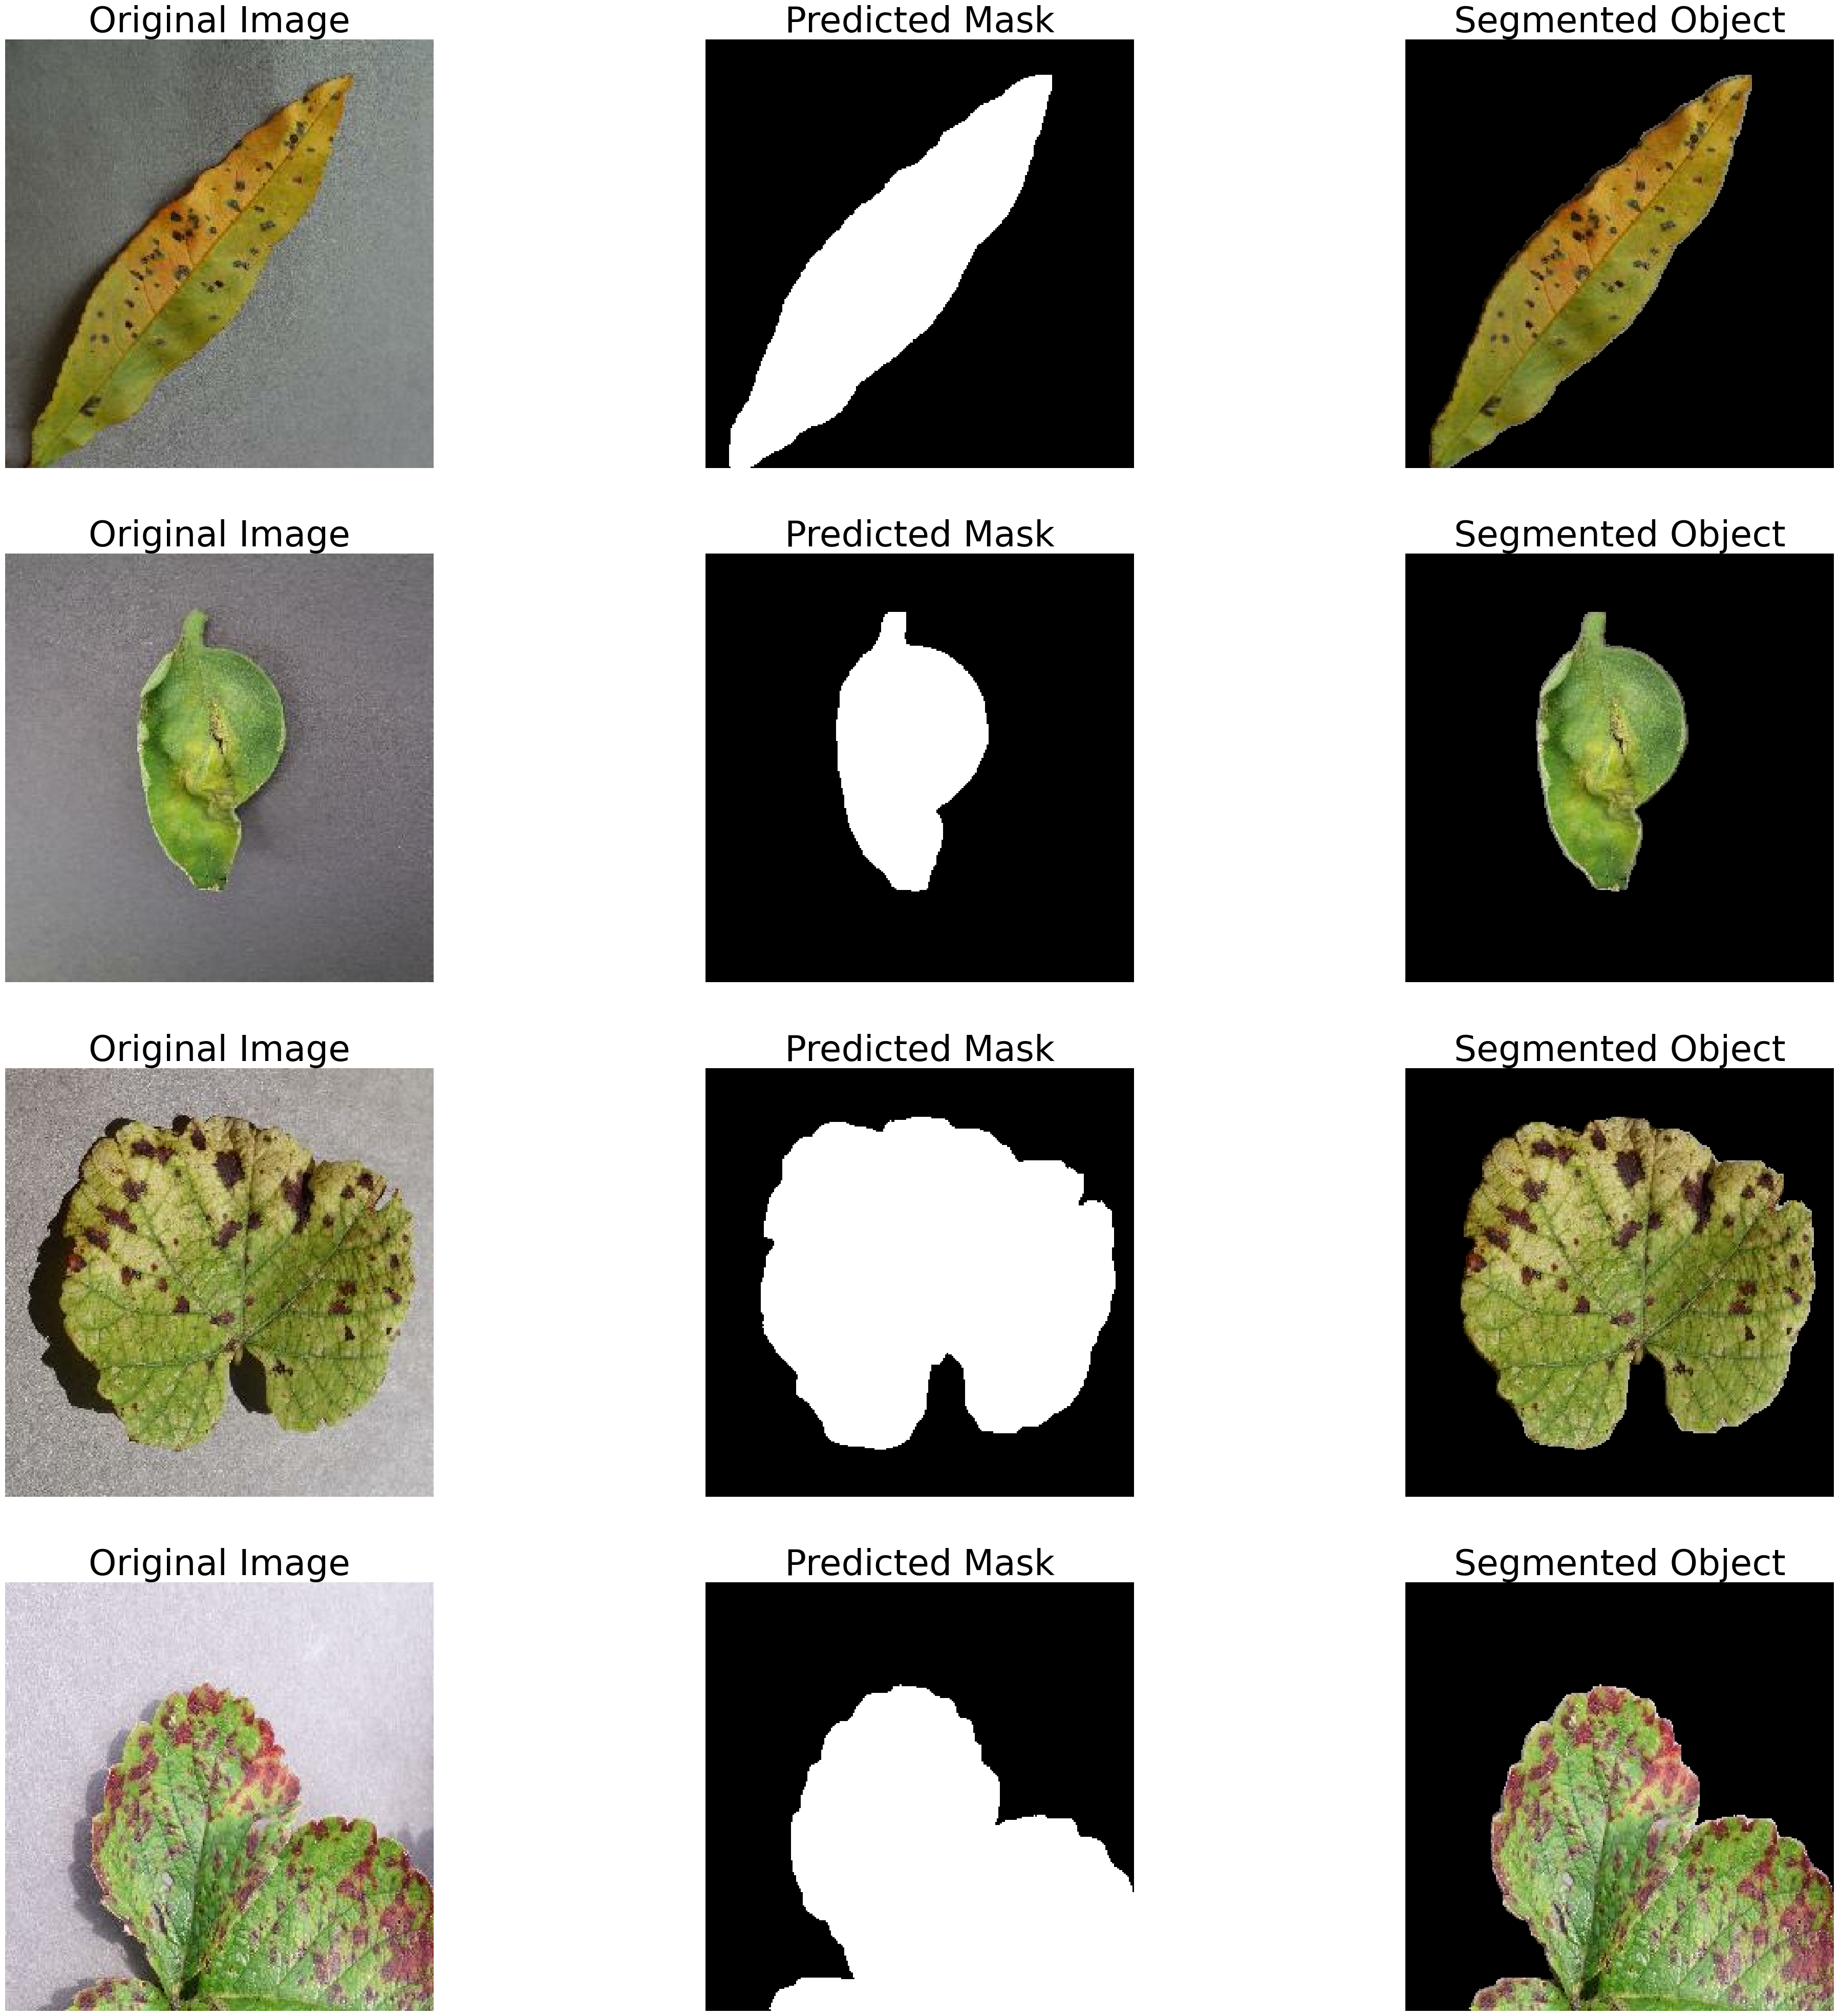

In [470]:
folder_path="samples"

images_dir=sorted(glob.glob(os.path.join(folder_path,r"**/*.*"),recursive=True))  ## Read images with any extension (jpg or JPG or jpeg or png)

samples=[] 
for img_path in images_dir:
    img = read_image(img_path)
    # The segmentation model was trained on BGR images.
    img = RGB2BGR(img)
    samples.append(img)

visualize_segmented_results(LiteUNet_model,samples)

# Super Resolution

In [471]:
def visualize_super_resolution_results(LR_samples,HR_samples):
    
    fig=plt.figure(figsize=(50,50))       
    num_imgs=len(HR_samples)
    
    for i,(LR_img,HR_img) in enumerate(zip(LR_samples,HR_samples)):
        SR_img=get_super_resolution_version(LR_img,HR_img.shape[0]//LR_img.shape[0])
        Bicubic_img=cv2.resize(LR_img,(HR_img.shape[0],HR_img.shape[1]),interpolation=cv2.INTER_CUBIC)
        
        fig.add_subplot(num_imgs,4,(i*4)+1)
        plt.title("LR Image",fontsize=50);
        plt.axis('off');
        plt.imshow(LR_img);

        
        fig.add_subplot(num_imgs,4,(i*4)+2)
        plt.title("Bicubic Image",fontsize=50);
        plt.axis('off');
        plt.imshow(Bicubic_img);
        
        fig.add_subplot(num_imgs,4,(i*4)+3)
        plt.title("SR Image",fontsize=50);
        plt.axis('off');
        plt.imshow(SR_img);

        fig.add_subplot(num_imgs,4,(i*4)+4)
        plt.title("HR Image",fontsize=50);
        plt.axis('off');
        plt.imshow(HR_img);
        

1/1 [==============================] - 0s 477ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 77ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 75ms/step


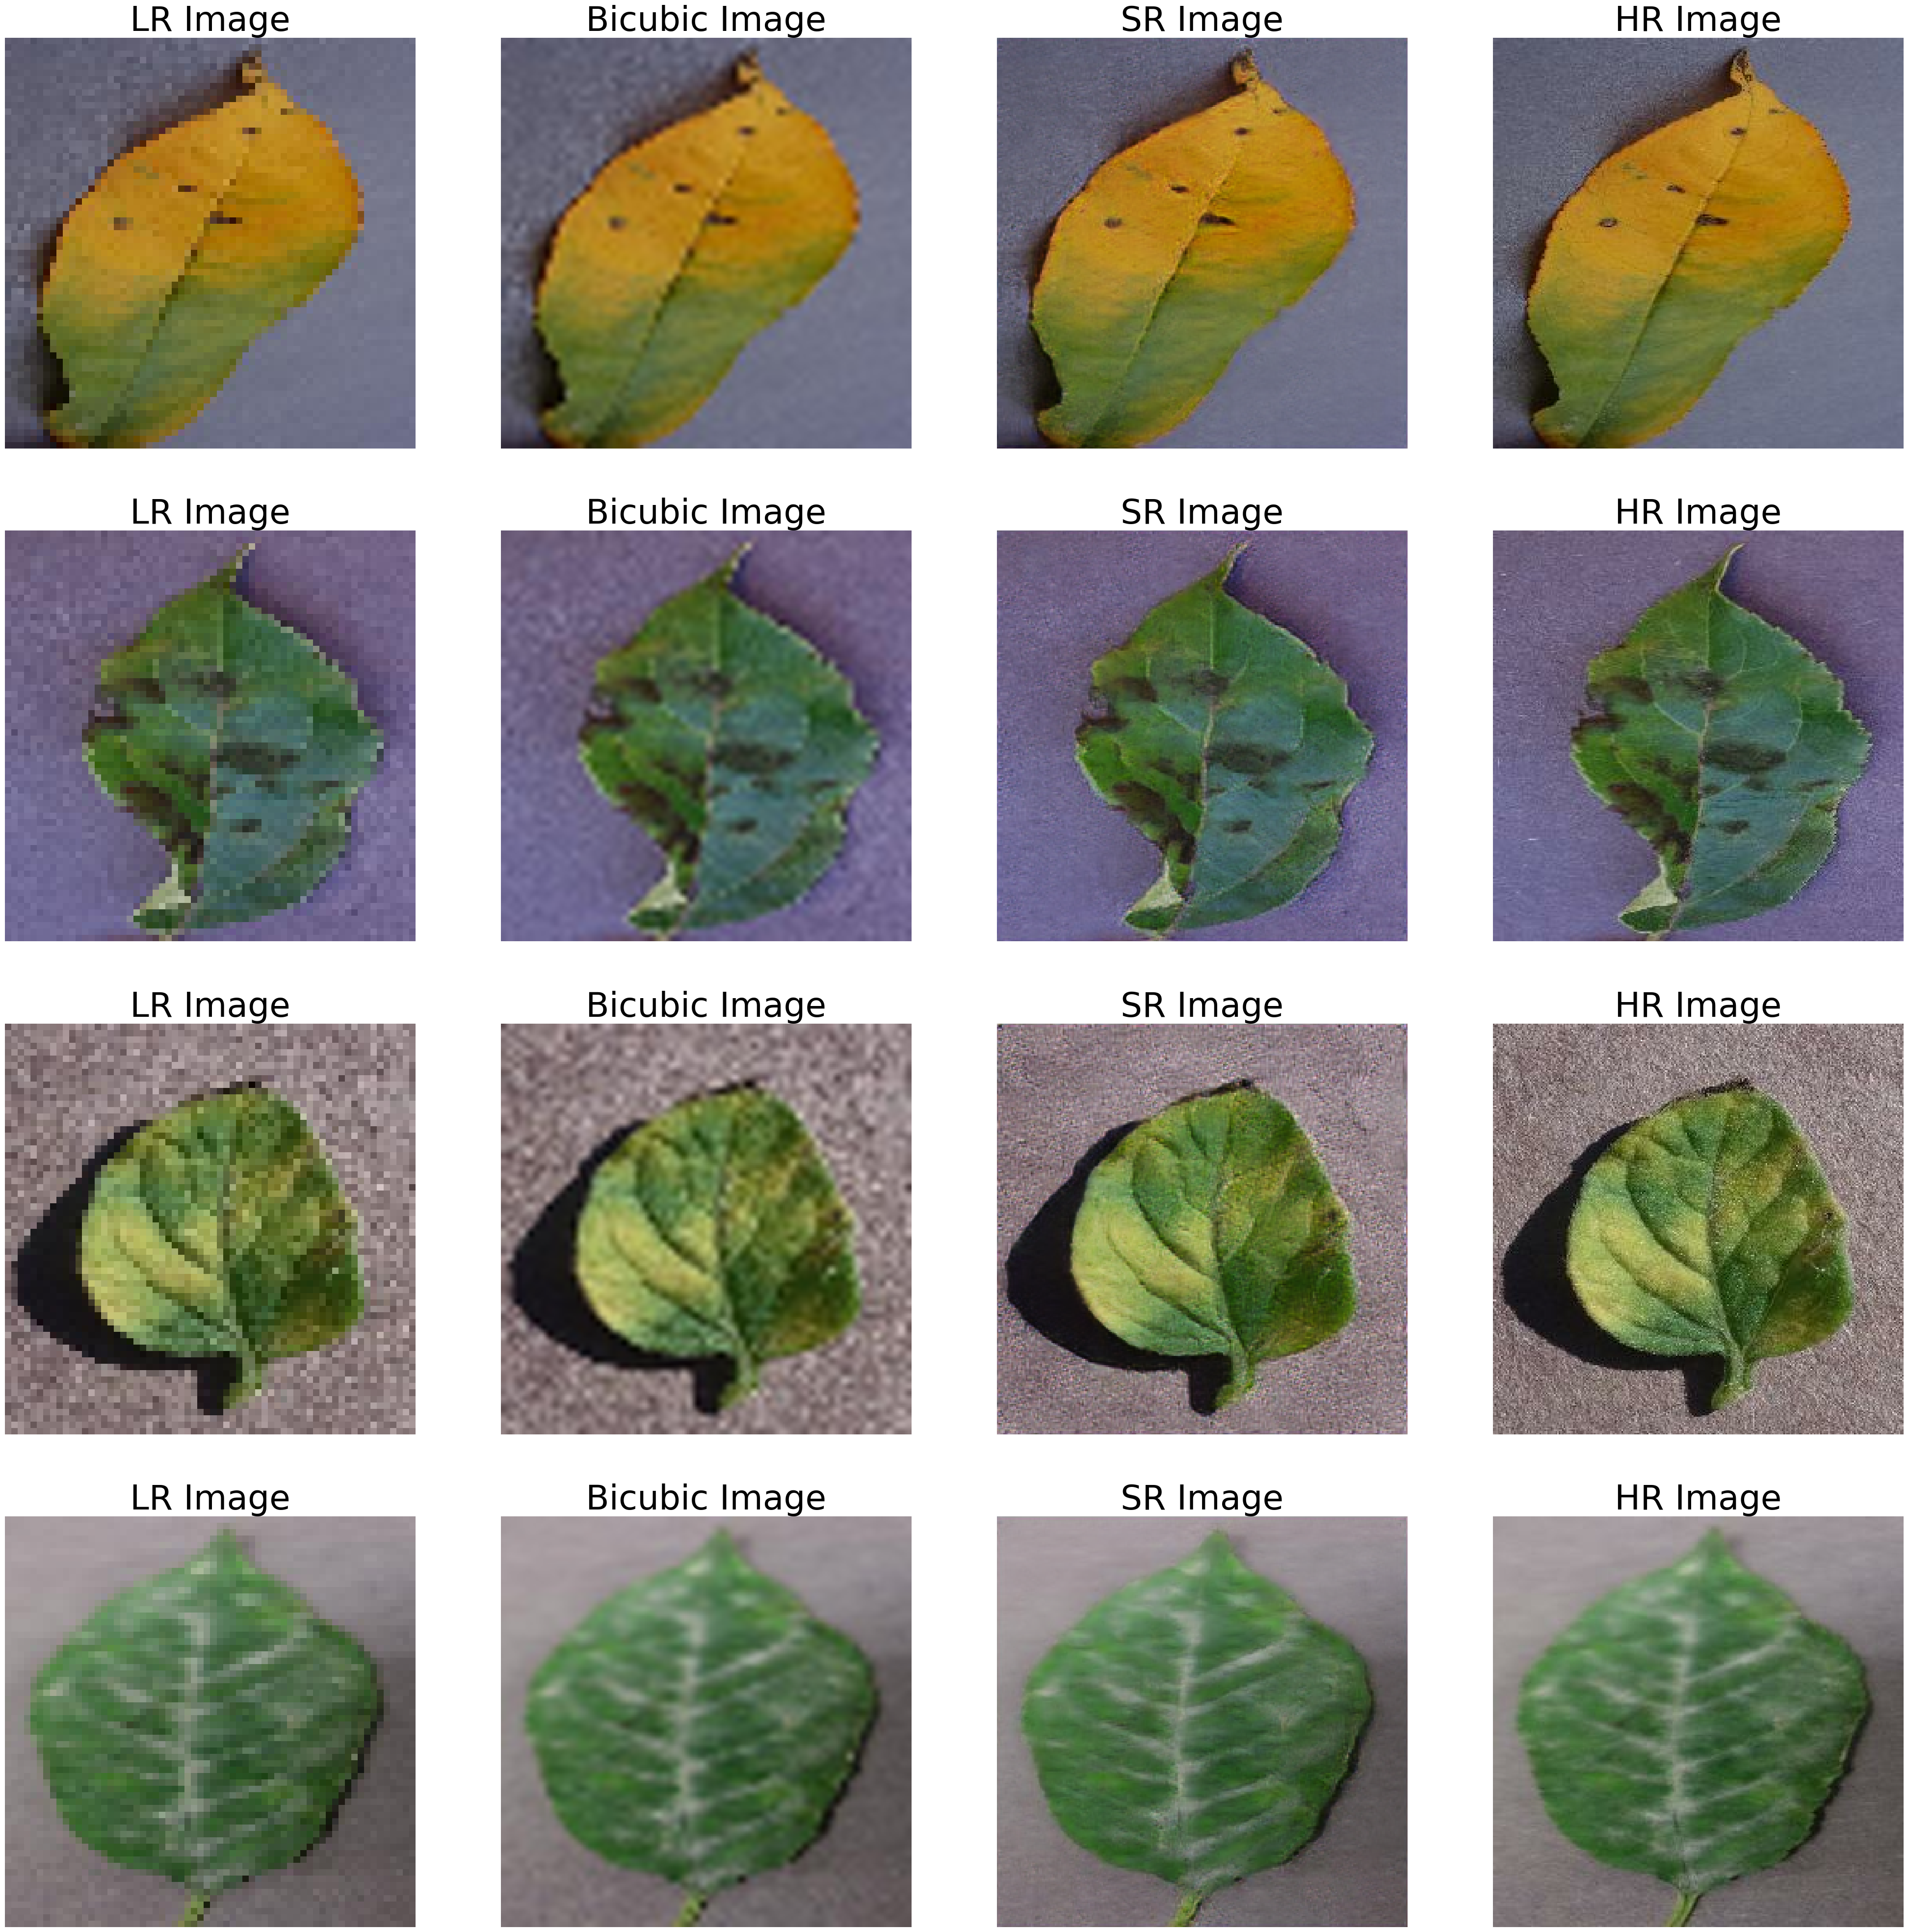

In [472]:
LR_folder_path="LR_samples"
HR_folder_path="HR_samples"

LR_images_dir=sorted(glob.glob(os.path.join(LR_folder_path,r"**/*.*"),recursive=True))
HR_images_dir=sorted(glob.glob(os.path.join(HR_folder_path,r"**/*.*"),recursive=True))

LR_samples = []
HR_samples = []

for LR_path , HR_path in zip(LR_images_dir,HR_images_dir):
        LR_img = read_image(LR_path,False)
        HR_img = read_image(HR_path)
        LR_samples.append(LR_img)
        HR_samples.append(HR_img)
        
visualize_super_resolution_results(LR_samples,HR_samples)

# Full Methodology
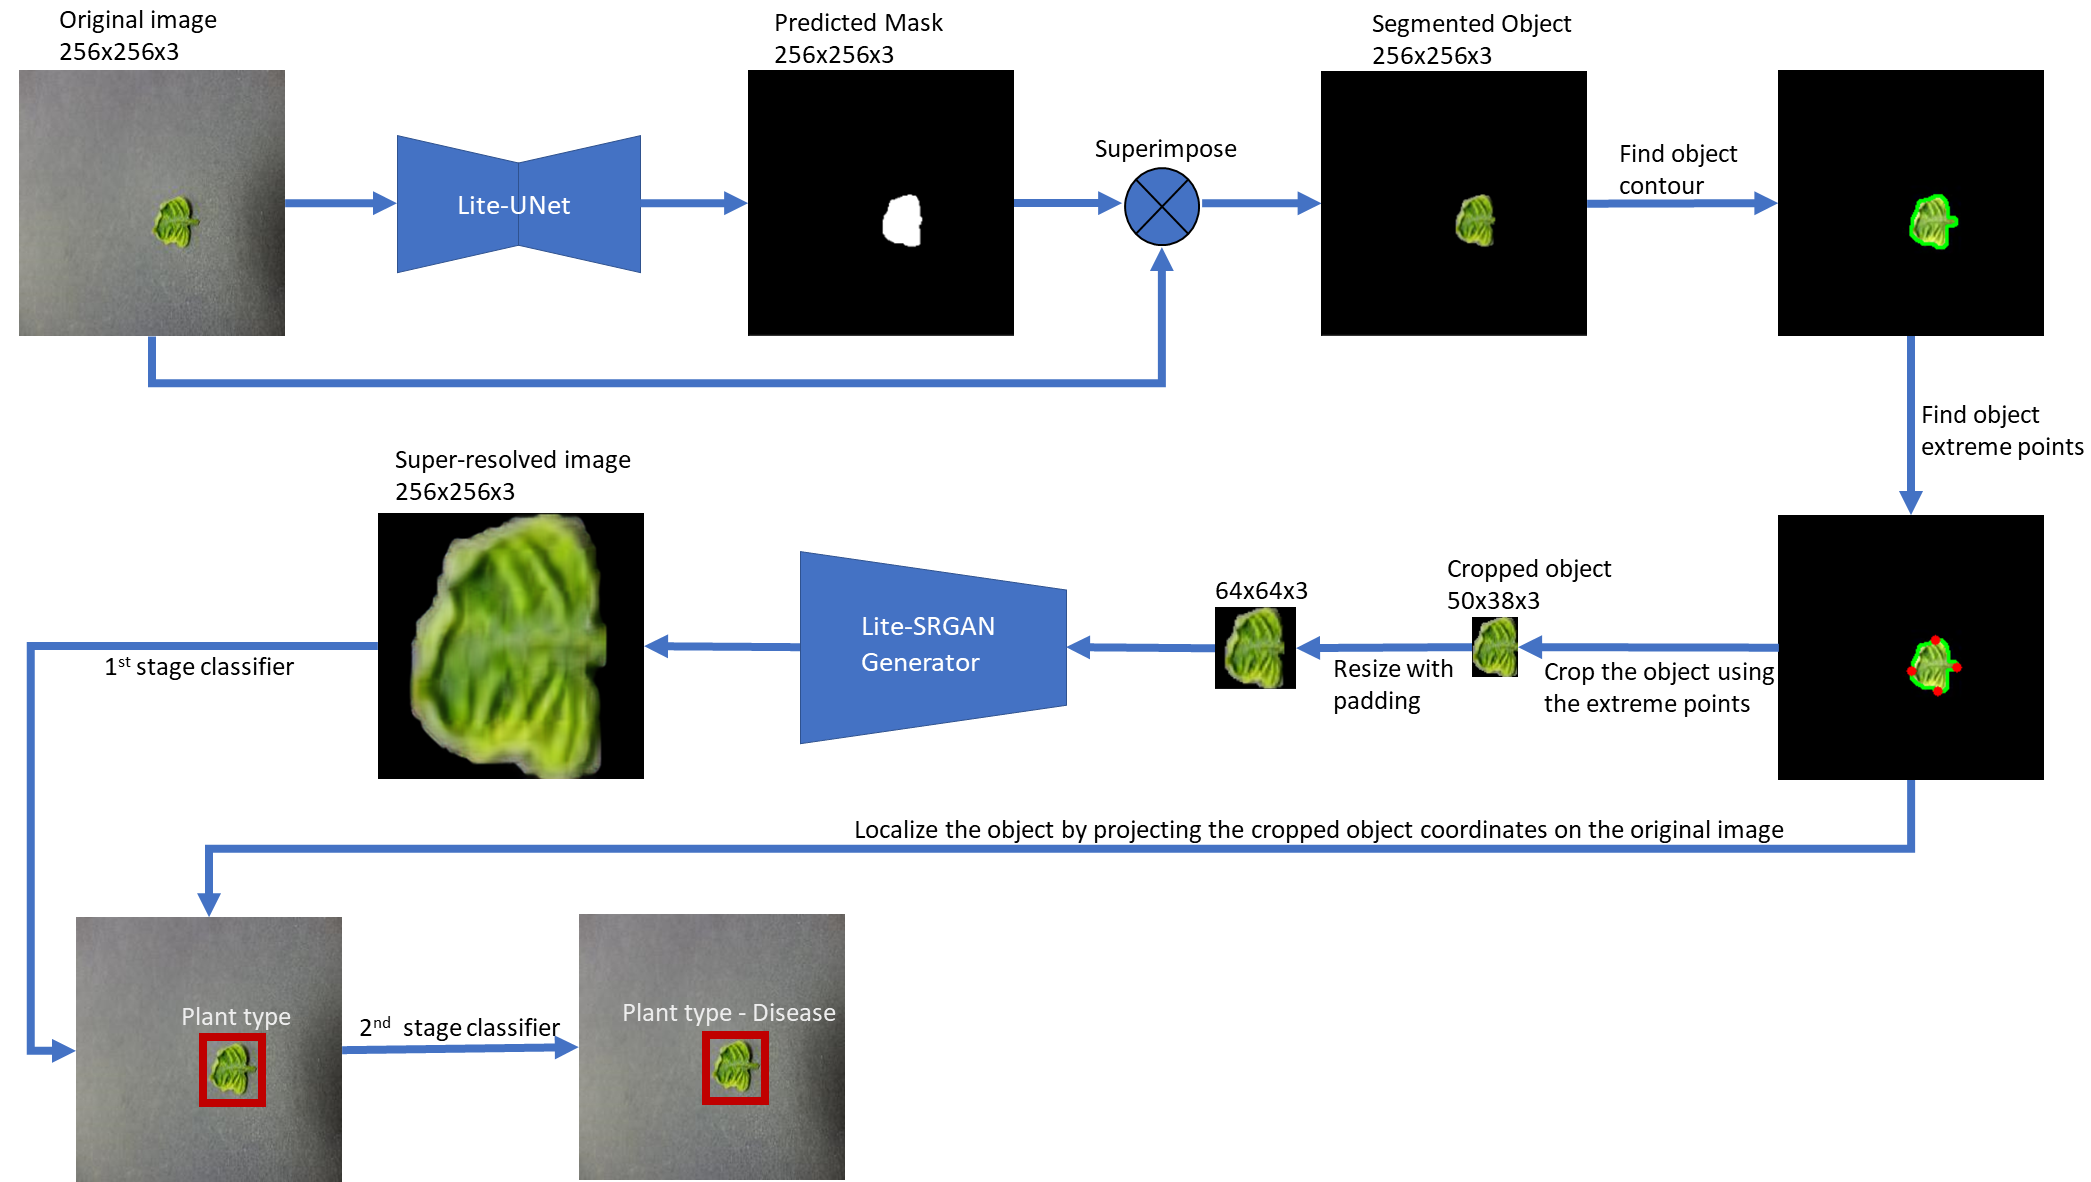

### Original Sample Image

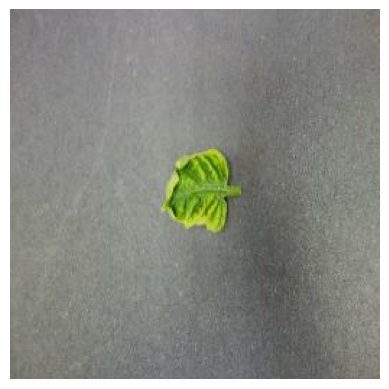

In [473]:
leaf_img = read_image(IMAGE_PATH)
plt.imshow(leaf_img)
plt.axis('off');
plt.show();

### Lite-UNet prediciton

1/1 [==============================] - 0s 78ms/step


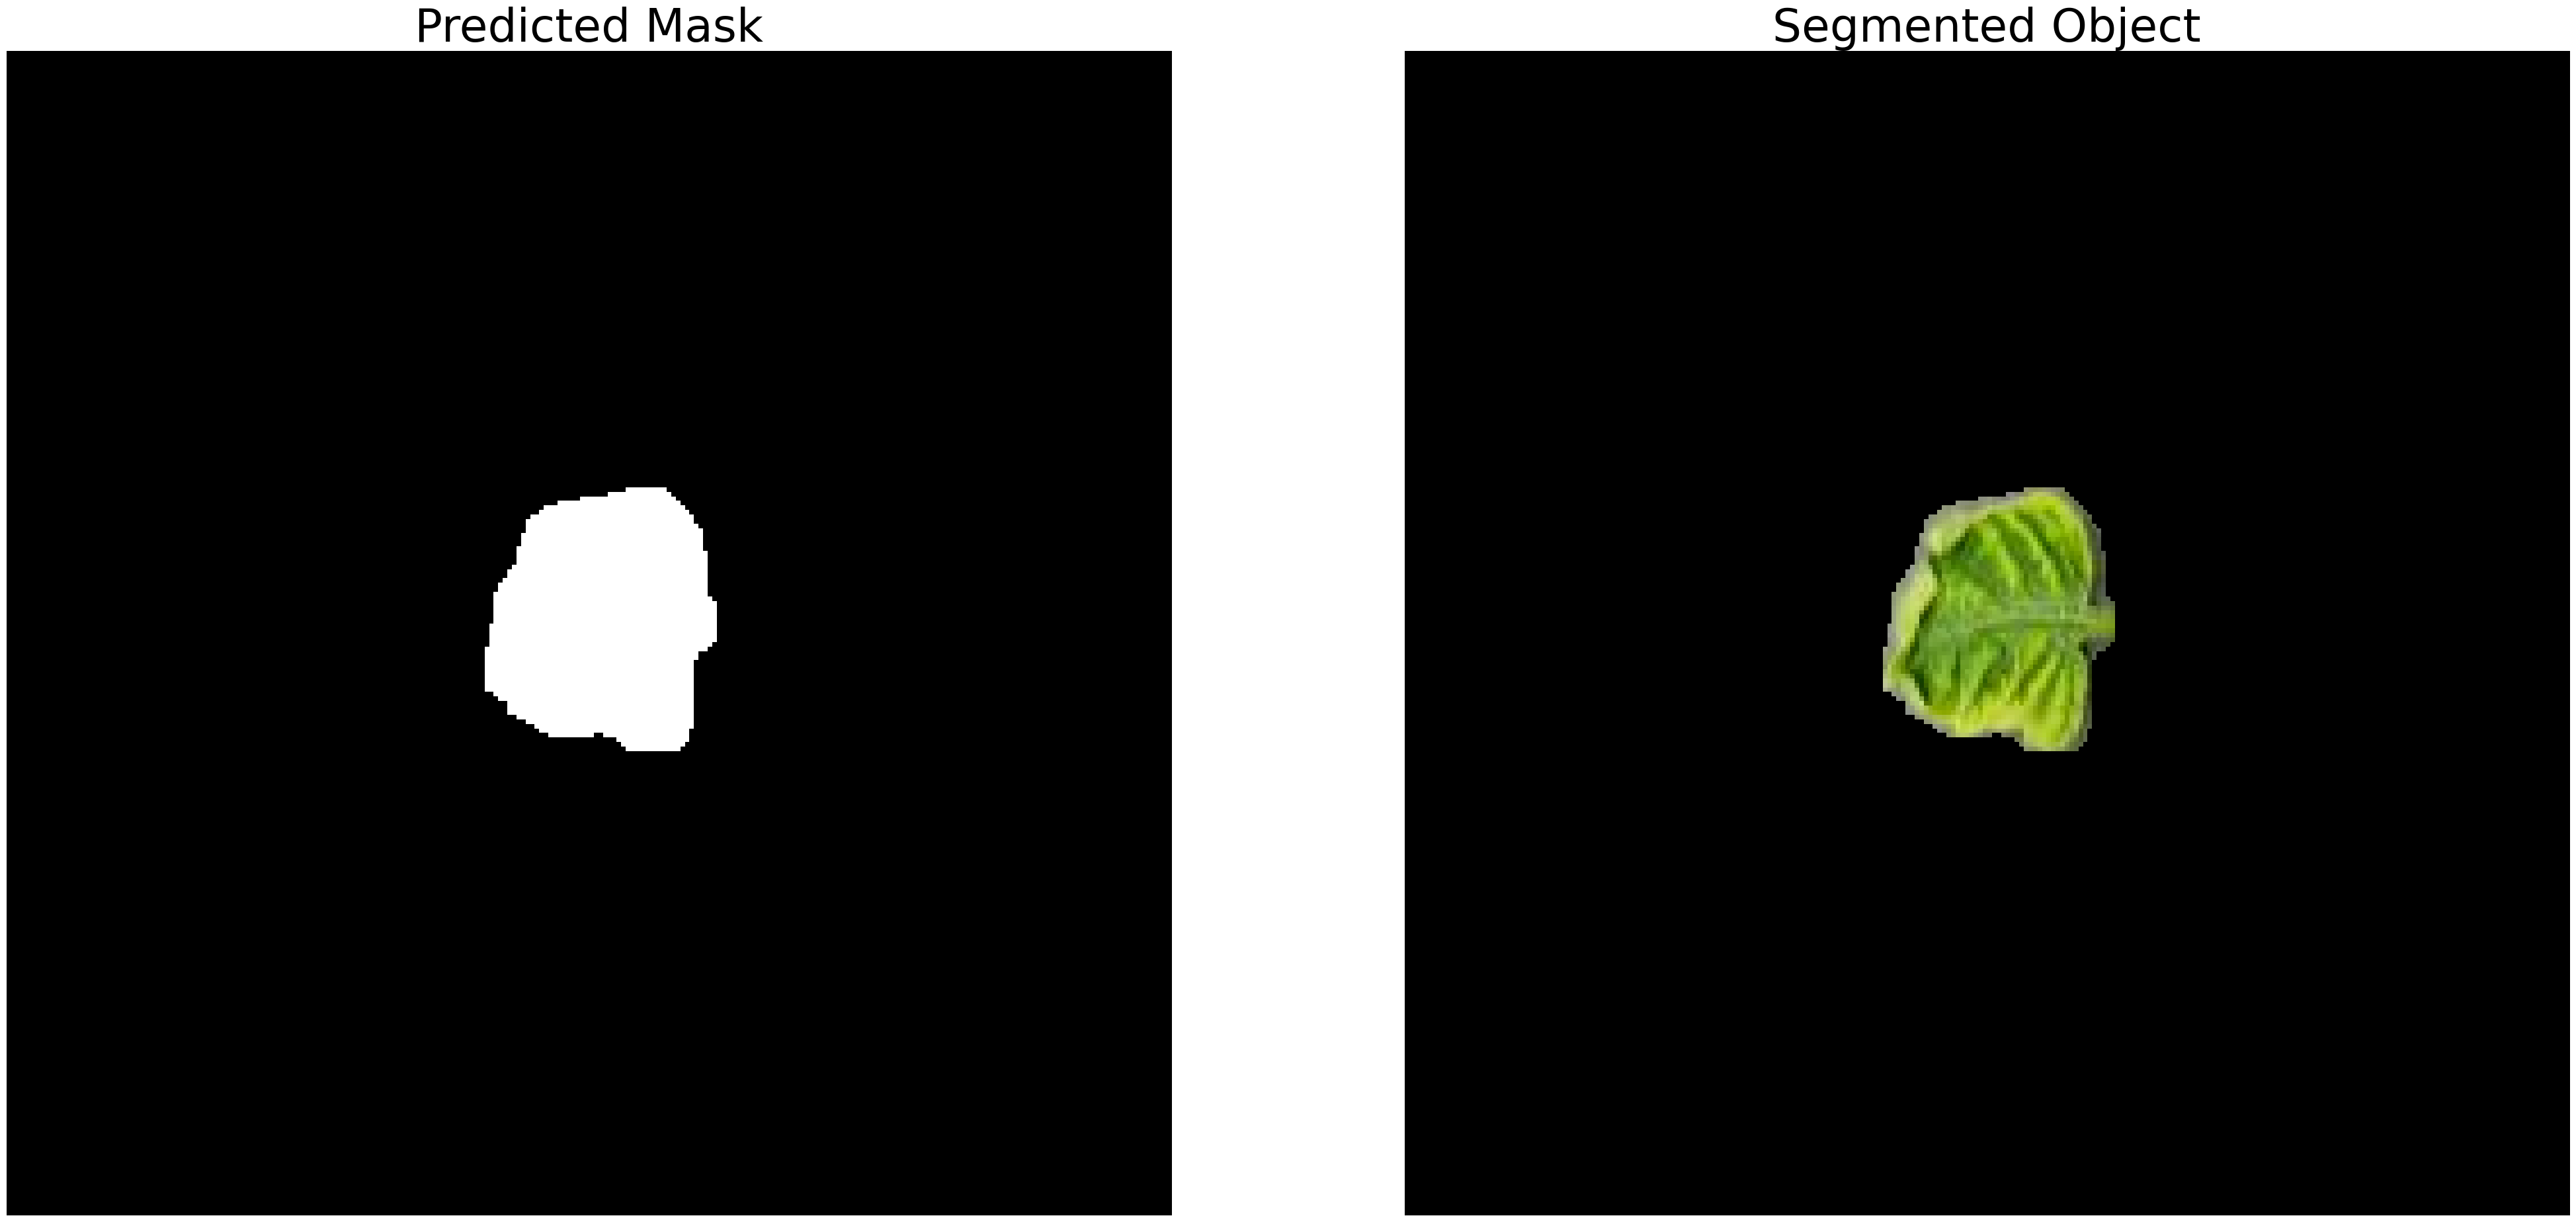

In [474]:
segmented_object,predicted_mask=get_segemented_image(RGB2BGR(leaf_img),LiteUNet_model)
segmented_object=(segmented_object*255).astype(np.uint8)

fig=plt.figure(figsize=(50,50))
fig.add_subplot(1,2,1)
plt.imshow(predicted_mask,cmap='gray')
plt.title("Predicted Mask",fontsize=50);
plt.axis('off');


fig.add_subplot(1,2,2);
plt.imshow(BGR2RGB(segmented_object));
plt.title("Segmented Object",fontsize=50);
plt.axis('off');


### Cropped Region of Interest

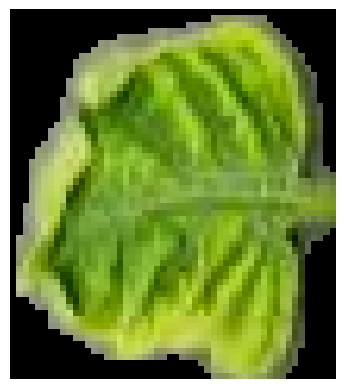

In [475]:
cropped=True
segmented_obj_cropped=None

try:
    segmented_obj_cropped=BGR2RGB(cropImage(predicted_mask,segmented_object))

except:
    cropped=False
    
plt.imshow(segmented_obj_cropped)
plt.axis('off');


### Localization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


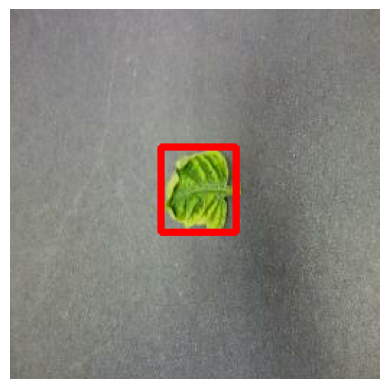

In [476]:
ROI,ROI_coordinates=LocalizeObject(leaf_img,predicted_mask)
plt.imshow(ROI);
plt.axis('off');

### Lite-SRGAN Prediction

1/1 [==============================] - 0s 83ms/step


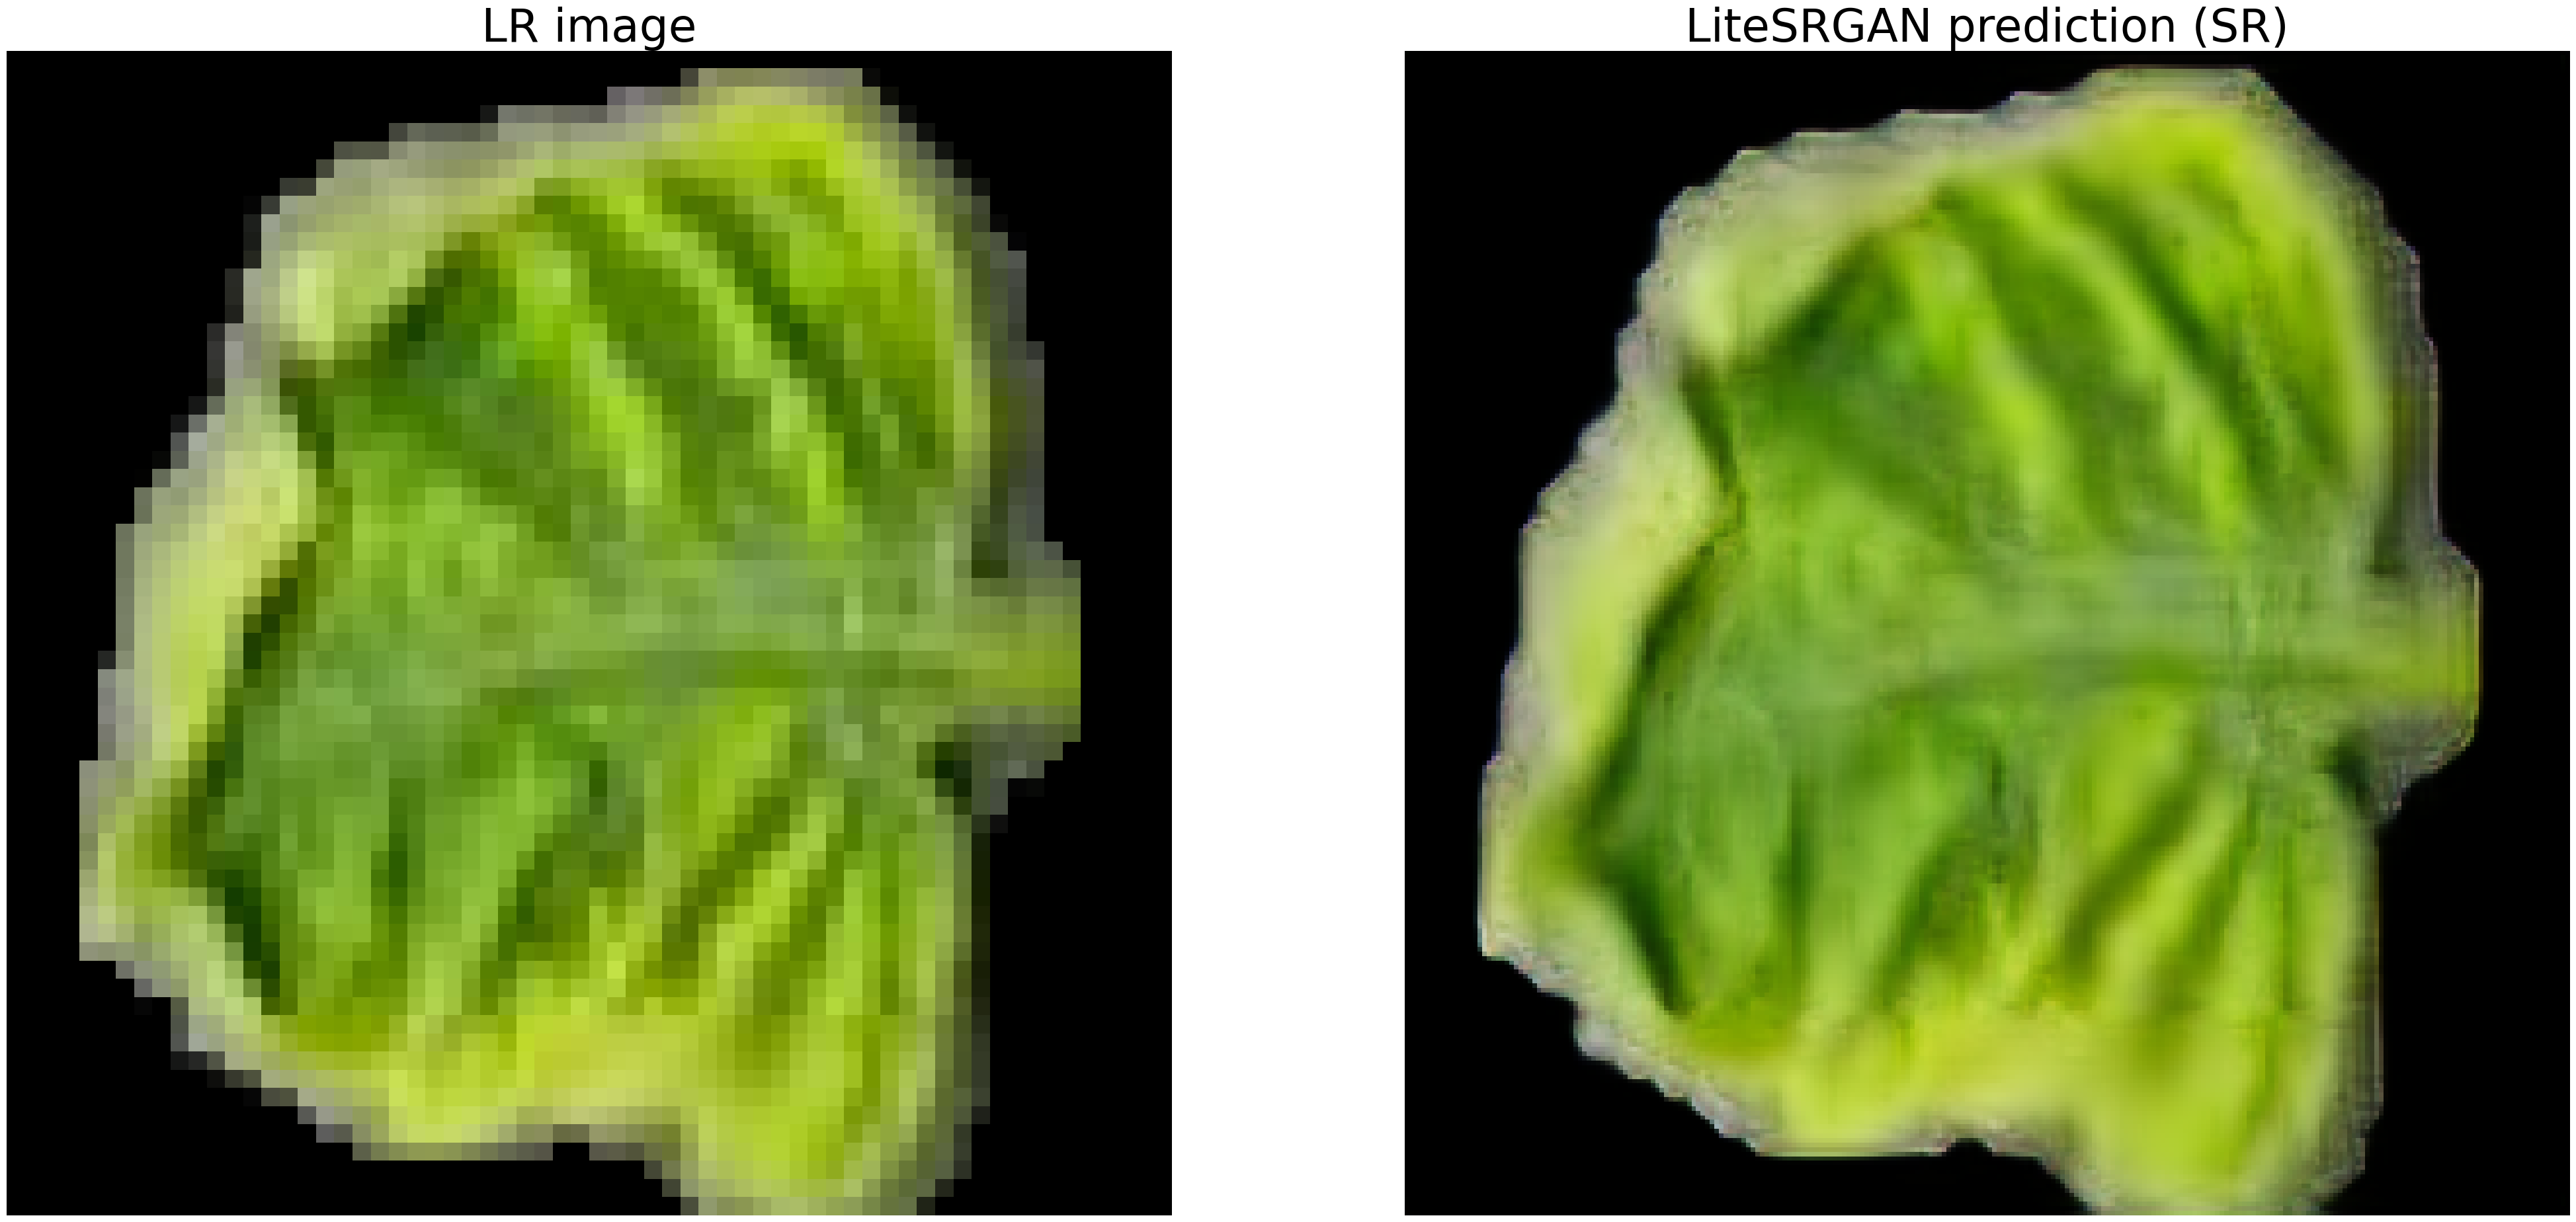

In [477]:
super_resolution_state=None
SR_img=None
preprocessed_img=None
if cropped==True:
    super_resolution_state=apply_super_resolution(segmented_obj_cropped)
    if super_resolution_state==1:    
        # The cropped image both dimensions is already larger than 64 and 128 , so we will take the original segmented leaf image (same if we did zero padding as the image is already segmented)
        segmented_obj_cropped=get_padded_img(segmented_obj_cropped,1)
        segmented_obj_cropped = (segmented_obj_cropped*255).astype(np.uint8)
        preprocessed_img=segmented_obj_cropped.copy()

    elif super_resolution_state==2:
        # zero pad both dimension to 128*128 , then use Light-SRGAN generator (1 upsampling block version) to obtain 256*256 image
        SR_img=get_super_resolution_version(segmented_obj_cropped,super_resolution_state)
        preprocessed_img=SR_img.copy()
        
    elif super_resolution_state==4:
        # zero pad both dimension to 64*64 , then use Light-SRGAN generator (2 upsampling block version) to obtain 256*256 image
        SR_img=get_super_resolution_version(segmented_obj_cropped,super_resolution_state)
        preprocessed_img=SR_img.copy()

if np.any(SR_img):   
    fig=plt.figure(figsize=(50,50));
    fig.add_subplot(1,2,1);
    plt.imshow((get_padded_img(segmented_obj_cropped,super_resolution_state)));
    plt.title("LR image",fontsize=50);
    plt.axis('off');


    fig.add_subplot(1,2,2);
    plt.imshow(SR_img);
    plt.title("LiteSRGAN prediction (SR)",fontsize=50);
    plt.axis('off');

else:
    print("The cropped object is relatively large so no super-resolution is applicable for this current resolution")
    plt.imshow(get_padded_img(segmented_obj_cropped,super_resolution_state));
    plt.xticks([]);
    plt.yticks([]);
    plt.show();
    

### First Stage Classification

In [478]:
classes=['Apple','Cherry','Corn','Grape','Peach','Pepper','Potato','Strawberry','Tomato']
class_label={class_name:label for label , class_name in enumerate(classes)}

Stage1_model=load_model('Stage1.h5',compile=False)

# classification models were trained on BGR mode
preprocessed_img=RGB2BGR(preprocessed_img)
Stage1_prediction=np.argmax(Stage1_model.predict(np.expand_dims(preprocessed_img,0)))

1/1 [==============================] - 1s 817ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tomato


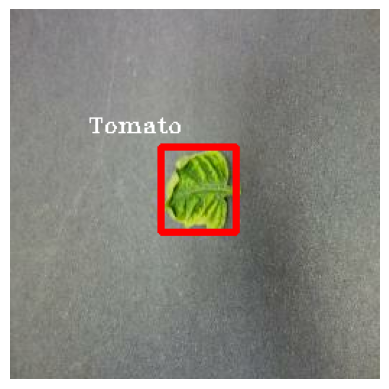

In [479]:
print(classes[Stage1_prediction])
ROI=cv2.putText(ROI,classes[Stage1_prediction],(ROI_coordinates[0]-50,ROI_coordinates[1]-10),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255,255,255))
plt.imshow(ROI);
plt.axis('off');

### Second Stage Classification

In [480]:
Stage2_model=load_model('Stage2_{}.h5'.format(classes[Stage1_prediction]),compile=False)
stage2_prediction=Stage2_model.predict(np.expand_dims(preprocessed_img,0))
f=open('{}.json'.format(classes[Stage1_prediction]))
data=json.load(f)
Stage2_label=data['{}'.format(np.argmax(stage2_prediction))]

1/1 [==============================] - 1s 659ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Curl virus


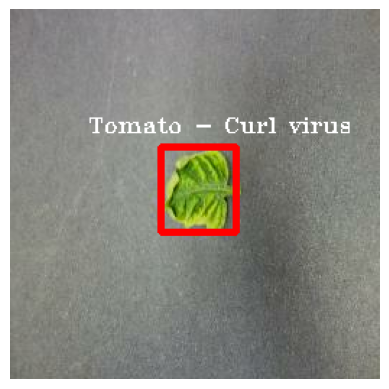

In [481]:
print(Stage2_label)
ROI=cv2.putText(ROI,' - {}'.format(Stage2_label),(ROI_coordinates[0]+15,ROI_coordinates[1]-10),fontFace=cv2.FONT_HERSHEY_TRIPLEX,fontScale=0.5,color=(255,255,255));
plt.imshow(ROI);
plt.axis('off');